In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import re
import sys
import os

In [6]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty and np.isfinite(data).all():
            margin = 0.05 * (data.max() - data.min()) if data.max() != data.min() else 0.5
            x_min = data.min() - margin
            x_max = data.max() + margin
            
            # Graficamos el histograma usando bins automáticos para mejor adaptación
            sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
            axes[idx].set_title(f'Distribución de {col}')
            
            # Solo establecer límites si son finitos
            if np.isfinite(x_min) and np.isfinite(x_max):
                axes[idx].set_xlim(x_min, x_max)
        else:
            # Si no hay datos válidos o contiene infinitos/NaN
            axes[idx].text(0.5, 0.5, 'No hay datos válidos para graficar',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[idx].transAxes)
            axes[idx].set_title(f'Distribución de {col}')

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        # Filtrar columnas numéricas que contienen valores infinitos o NaN
        valid_numeric_cols = []
        for col in numeric_cols:
            if df[col].dropna().empty or not np.isfinite(df[col].dropna()).all():
                print(f"Advertencia: La columna '{col}' contiene valores no finitos y no será graficada.")
            else:
                valid_numeric_cols.append(col)
        
        if valid_numeric_cols:
            plot_numeric_analysis(df, valid_numeric_cols)
        else:
            print("No hay columnas numéricas válidas para graficar.")
    return

|                                                Análisis de la tabla S&P 500                                               |
Dimensiones: (24406, 17)


/home/pablo-herrera/.local/share/mamba/envs/proyecto_dm/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/pablo-herrera/.local/share/mamba/envs/proyecto_dm/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | SMA_20             | SMA_50             | RSI_14             | MACD_12_26_9        | MACDh_12_26_9          | MACDs_12_26_9      | BBL_20_2.0         | BBM_20_2.0         | BBU_20_2.0        | BBB_20_2.0         | BBP_20_2.0         |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:--------------------|:-----------------------|:-------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|
| Valores Únicos                | 24406           | 16885              | 16887              | 16884              | 13774              | 13127              | 19108   

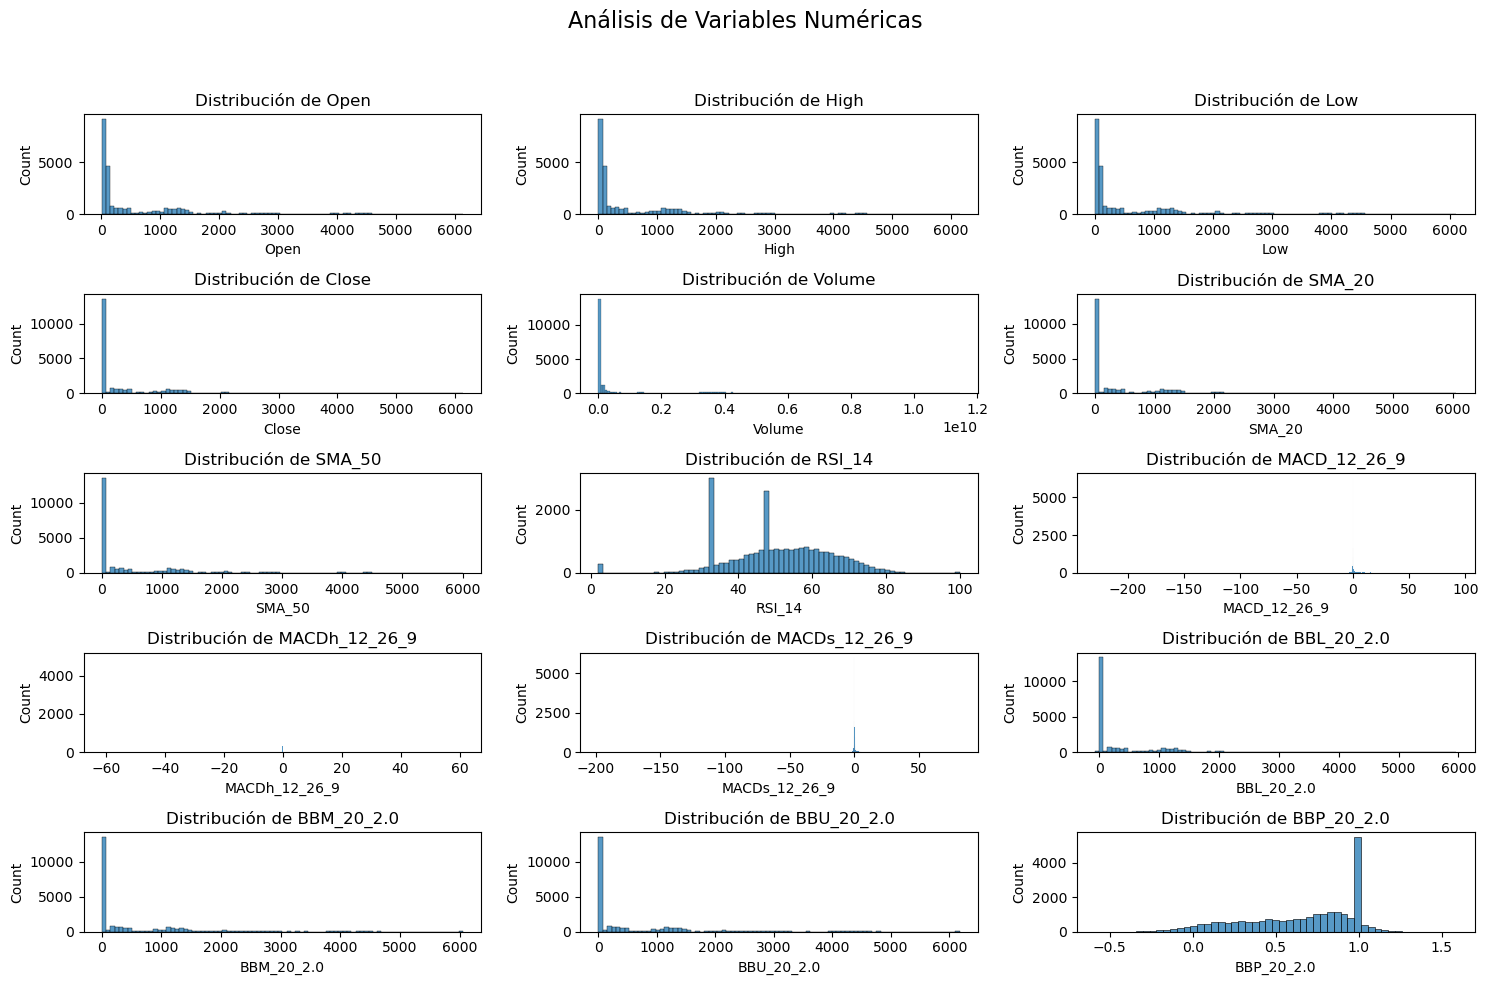

In [7]:
sp500_data = pd.read_csv('../data/raw/^GSPC_data.csv')
analisis_exploratorio('S&P 500', sp500_data)

In [ ]:
apple_data = pd.read_csv('../data/raw/AAPL_data.csv')
analisis_exploratorio('Apple', apple_data)

|                                                 Análisis de la tabla Apple                                                |
Dimensiones: (11144, 17)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open                | High               | Low                 | Close              | Volume            | SMA_20             | SMA_50             | RSI_14             | MACD_12_26_9        | MACDh_12_26_9         | MACDs_12_26_9       | BBL_20_2.0         | BBM_20_2.0         | BBU_20_2.0         | BBB_20_2.0         | BBP_20_2.0          |
|:------------------------------|:----------------|:--------------------|:-------------------|:--------------------|:-------------------|:------------------|:-------------------|:-------------------|:-------------------|:--------------------|:----------------------|:--------------------|:-------------------|:-------------------|:-------------------|:-------------------|:--------------------|
| Valore

In [ ]:
microsoft_data = pd.read_csv('../data/raw/MSFT_data.csv')
analisis_exploratorio('Microsoft', microsoft_data)

In [22]:
#Abrir el archivo data/raw/Airbnb_Data.csv
data = pd.read_csv('../data/raw/Airbnb_Data.csv')
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


: 

In [23]:
print(data.dtypes)

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object


In [24]:
#Ver valores nulos de todas las filas
data.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

Tratamiento de valores nulos

In [25]:
#Ver valores únicos de cada feature de valores enteros por el nombre de la columna
for column in data.columns:
    if column == 'bathrooms' or column == 'bed_type' or column == 'cancellation_policy' or column == 'cleaning_fee' or column=='host_has_profile_pic' or\
    column == 'host_identity_verified' or column == 'host_response_rate' or column == 'instant_bookable' or column == 'property_type' or column == 'room_type'\
    or column=='bedrooms' or column=='beds' or column=='accommodates' :
        print(column)
        print(data[column].unique())
        print('----------------------------------')

property_type
['Apartment' 'House' 'Condominium' 'Loft' 'Townhouse' 'Hostel'
 'Guest suite' 'Bed & Breakfast' 'Bungalow' 'Guesthouse' 'Dorm' 'Other'
 'Camper/RV' 'Villa' 'Boutique hotel' 'Timeshare' 'In-law' 'Boat'
 'Serviced apartment' 'Castle' 'Cabin' 'Treehouse' 'Tipi' 'Vacation home'
 'Tent' 'Hut' 'Casa particular' 'Chalet' 'Yurt' 'Earth House'
 'Parking Space' 'Train' 'Cave' 'Lighthouse' 'Island']
----------------------------------
room_type
['Entire home/apt' 'Private room' 'Shared room']
----------------------------------
accommodates
[ 3  7  5  4  2  6  8  1  9 10 16 11 12 14 13 15]
----------------------------------
bathrooms
[1.  1.5 2.  nan 2.5 3.  0.5 4.5 5.  0.  4.  3.5 5.5 7.5 6.  8.  7.  6.5]
----------------------------------
bed_type
['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']
----------------------------------
cancellation_policy
['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']
----------------------------------
cleaning_fee
[ True False]

In [26]:
#Valores nulos en la columna 'bathrooms'
nulos_bathrooms = data[data['bathrooms'].isnull()]
#Imprimir los valores unicos de cada feature para ver si hay relacion de este valor nulo con otro feature
for col in data.columns:
    print(col)
    if len(nulos_bathrooms[col].unique()) > 5:
        print(nulos_bathrooms[col].unique()[:5], '...')
    else:
        print(nulos_bathrooms[col].unique())
    

id
[10994968 12232154 13559613 13068133 13928644] ...
log_price
[4.48863637 4.74493213 4.60517019 5.16478597 5.29831737] ...
property_type
['House' 'Apartment' 'Bed & Breakfast' 'Dorm' 'Camper/RV'] ...
room_type
['Private room' 'Entire home/apt' 'Shared room']
amenities
['{Internet,"Wireless Internet",Kitchen,"Pets live on this property",Cat(s),Heating,"Family/kid friendly",Washer,Dryer,Hangers,"Hair dryer","Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{Internet,"Wireless Internet",Kitchen,"Pets allowed","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer}'
 '{}'
 '{Internet,"Wireless Internet","Air conditioning",Shampoo,Hangers,"Hair dryer",Iron,"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{"Wireless Internet",Kitchen,"Smoking allowed","Pets allowed","Buzzer/wireless intercom",Heating,"Smoke detector","Carbon monoxide detector","Fire extinguisher"}']

In [27]:
#Ver si 'bathrooms' tiene valores 0, si los tiene cambiarlos por -1 los nulos, caso contrario cambiarlos por 0
num_0_bathrooms = (data['bathrooms'] == 0).sum()
print("Numero de valores 0 en 'bathrooms':", num_0_bathrooms)
if num_0_bathrooms > 0:
    data.fillna({'bathrooms': -1}, inplace=True)
else:
    data.fillna({'bathrooms': 0}, inplace=True)

Numero de valores 0 en 'bathrooms': 198


In [28]:
#Valores nulos en 'first_review'
nulos_first_review = data[data['first_review'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
for col in nulos_first_review.columns:
    print(col)
    if len(nulos_first_review[col].unique()) > 5:
        print(nulos_first_review[col].unique()[:5], '...')
    else:
        print(nulos_first_review[col].unique())



id
[13418779 14066228  6226658  2479317  5520582] ...
log_price
[6.62007321 4.24849524 4.09434456 6.95654544 3.8286414 ] ...
property_type
['House' 'Apartment' 'Condominium' 'Loft' 'Townhouse'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials}'
 '{TV,Internet,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Pets live on this property",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers}'
 '{Internet,"Wireless Internet","Air conditioning",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,Essentials,Hangers,"Laptop friendly workspace"}'
 '{TV,"Wireless Internet","Air conditioning",Kitchen,Heating,Washer,Dryer,"Smoke detector","Fire ex

In [29]:
#Ver el min datetime que acepta un timestamp de pandas
pd.Timestamp.min

Timestamp('1677-09-21 00:12:43.145224193')

In [30]:
#Cambiar first review a datetime "1677-10-21" en valores nulos
data['first_review'] = data['first_review'].fillna('1677-10-21')
print(data['first_review'].isnull().sum())
#Cambiar el tipo de dato de 'first_review' a datetime
data['first_review'] = pd.to_datetime(data['first_review'])
print(data['first_review'].dtype)

0
datetime64[ns]


In [31]:
#Valores nulos de host_has_profile_pic
nulos_host_has_profile_pic = data[data['host_has_profile_pic'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relación de este valor nulo con otro feature
for col in nulos_host_has_profile_pic.columns:
    print(col)
    if len(nulos_host_has_profile_pic[col].unique()) > 5:
        print(nulos_host_has_profile_pic[col].unique()[:5], '...')
    else:
        print(nulos_host_has_profile_pic[col].unique())

id
[  262343  4588783 18058045 20973084 15629616] ...
log_price
[4.70048037 4.17438727 5.5174529  4.24849524 5.29831737] ...
property_type
['Apartment' 'House' 'Condominium' 'Townhouse' 'Timeshare'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,Kitchen,Heating,"Smoke detector",Essentials,"Lock on bedroom door","Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{"Wireless Internet","Air conditioning",Kitchen,Heating,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Bed linens","Extra pillows and blankets","Ethernet connection",Microwave,Refrigerator,"Dishes and silverware",Stove,"Single level home","Luggage dropoff allowed","Long term stays allowed","Wide hallway clearance","Wide doorway","Step-free access","Wide doorway","Wide clearance to bed","Step-free access","Wide doorway","Fixed grab bars for shower & toilet

In [32]:
#Los nulos de host_has_profile_pic tambien tienen nulos en host_identity_verified,host_response_rate y host_since.
# Se cambia los valores t a 1, f a 0 y los nulos a -1. En el caso de host_since como son fechas se cambian a '1677-10-21' los nulos. Únicamente se
# cambian las filas que tienen nulos en host_has_profile_pic, ya que pueden haber otras relaciones extras en los otros campos nulos.
data.loc[data['host_has_profile_pic'].isnull(), 'host_identity_verified'] = data.loc[data['host_has_profile_pic'].isnull(), 'host_identity_verified'].fillna('-1')
data.loc[data['host_has_profile_pic'].isnull(), 'host_response_rate'] = data.loc[data['host_has_profile_pic'].isnull(), 'host_response_rate'].fillna('-1')
data.loc[data['host_has_profile_pic'].isnull(), 'host_since'] = data.loc[data['host_has_profile_pic'].isnull(), 'host_since'].fillna('1677-10-21')
#Se cambio host_has_profile_pic al final ya que es el campo filtro del resto de campos
data.loc[data['host_has_profile_pic'].isnull(), 'host_has_profile_pic'] = data.loc[data['host_has_profile_pic'].isnull(), 'host_has_profile_pic'].fillna('-1')
print(data['host_has_profile_pic'].unique())
print(data['host_identity_verified'].unique())
print(data['host_response_rate'].unique())
print(data['host_since'].unique())

#Mapeo de los otros valores a enteros
data['host_identity_verified'] = data['host_identity_verified'].map({'t': '1', 'f': '0'}).fillna(data['host_identity_verified'])
data['host_has_profile_pic'] = data['host_has_profile_pic'].map({'t': '1', 'f': '0'}).fillna(data['host_has_profile_pic'])
print(data['host_has_profile_pic'].unique())
print(data['host_identity_verified'].unique())
print(data['host_response_rate'].unique())
print(data['host_since'].unique())
#Convertir host_has_profile_pic a entero
data['host_has_profile_pic'] = data['host_has_profile_pic'].astype(int)
#Convertir host_since a datetime
data['host_since'] = pd.to_datetime(data['host_since'])
print(data['host_since'].dtype)


['t' '-1' 'f']
['t' 'f' '-1']
[nan '100%' '71%' '68%' '67%' '83%' '50%' '90%' '86%' '92%' '82%' '80%'
 '89%' '-1' '93%' '99%' '0%' '88%' '96%' '70%' '94%' '91%' '25%' '95%'
 '98%' '62%' '29%' '33%' '81%' '63%' '38%' '60%' '79%' '78%' '75%' '65%'
 '97%' '87%' '40%' '54%' '53%' '58%' '76%' '30%' '64%' '17%' '20%' '77%'
 '73%' '41%' '59%' '57%' '85%' '56%' '42%' '44%' '35%' '14%' '74%' '27%'
 '10%' '84%' '6%' '72%' '36%' '55%' '43%' '13%' '39%' '46%' '26%' '61%'
 '52%' '23%' '22%' '69%' '66%' '15%' '11%' '31%' '21%' '47%']
['2012-03-26' '2017-06-19' '2016-10-25' ... '2008-03-03' '2010-04-30'
 '2009-08-23']
['1' '-1' '0']
['1' '0' '-1']
[nan '100%' '71%' '68%' '67%' '83%' '50%' '90%' '86%' '92%' '82%' '80%'
 '89%' '-1' '93%' '99%' '0%' '88%' '96%' '70%' '94%' '91%' '25%' '95%'
 '98%' '62%' '29%' '33%' '81%' '63%' '38%' '60%' '79%' '78%' '75%' '65%'
 '97%' '87%' '40%' '54%' '53%' '58%' '76%' '30%' '64%' '17%' '20%' '77%'
 '73%' '41%' '59%' '57%' '85%' '56%' '42%' '44%' '35%' '14%' '74%' '27

In [33]:
#Valores nulos de host_identity_verified
nulos_host_identity_verified = data[data['host_identity_verified'].isnull()]
if len(nulos_host_identity_verified) > 0:
    #Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
    for col in nulos_host_identity_verified.columns:
        print(col)
        if len(nulos_host_identity_verified[col].unique()) > 5:
            print(nulos_host_identity_verified[col].unique()[:5], '...')
        else:
            print(nulos_host_identity_verified[col].unique())
else:
    print("No hay valores nulos en host_identity_verified")

No hay valores nulos en host_identity_verified


In [34]:
#Cibiar los valores de host_identity_verified a enteros
data['host_identity_verified'] = data['host_identity_verified'].astype(int)

In [35]:
#Valores nulos de host_response_rate
nulos_host_response_rate = data[data['host_response_rate'].isnull()]
if len(nulos_host_response_rate) > 0:
    #Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
    for col in nulos_host_response_rate.columns:
        print(col)
        if len(nulos_host_response_rate[col].unique()) > 5:
            print(nulos_host_response_rate[col].unique()[:5], '...')
        else:
            print(nulos_host_response_rate[col].unique())
else:
    print("No hay valores nulos en host_response_rate")



id
[ 6901257 13418779 14066228  7499179 17615783] ...
log_price
[5.01063529 6.62007321 4.24849524 4.31748811 4.00733319] ...
property_type
['Apartment' 'House' 'Loft' 'Condominium' 'Bed & Breakfast'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'
 '{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials}'
 '{TV,Internet,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Pets live on this property",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers}'
 '{TV,"Wireless Internet",Kitchen,"Pets allowed",Breakfast,"Pets live on this property",Heating,"Suitable for ev

In [36]:
#Llenar los nulos con -1 en host_response_rate
data['host_response_rate'] = data['host_response_rate'].fillna('-1')
#SI se tiene el simbolo % se quita y se convierte a entero
data['host_response_rate'] = data['host_response_rate'].str.replace('%', '').astype(int)

In [37]:
#Valores nulos de host_since
nulos_host_since = data[data['host_since'].isnull()]
if len(nulos_host_since) > 0:
    #Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
    for col in nulos_host_since.columns:
        print(col)
        if len(nulos_host_since[col].unique()) > 5:
            print(nulos_host_since[col].unique()[:5], '...')
        else:
            print(nulos_host_since[col].unique())
else:
    print("No hay valores nulos en host_since")

No hay valores nulos en host_since


In [38]:
#Valores nulos en 'last_review'}
nulos_last_review = data[data['last_review'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
for col in nulos_last_review.columns:
    print(col)
    if len(nulos_last_review[col].unique()) > 5:
        print(nulos_last_review[col].unique()[:5], '...')
    else:
        print(nulos_last_review[col].unique())



id
[13418779 14066228  6226658  2479317  5520582] ...
log_price
[6.62007321 4.24849524 4.09434456 6.95654544 3.8286414 ] ...
property_type
['House' 'Apartment' 'Condominium' 'Loft' 'Townhouse'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials}'
 '{TV,Internet,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Pets live on this property",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers}'
 '{Internet,"Wireless Internet","Air conditioning",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,Essentials,Hangers,"Laptop friendly workspace"}'
 '{TV,"Wireless Internet","Air conditioning",Kitchen,Heating,Washer,Dryer,"Smoke detector","Fire ex

In [39]:
#Cambiar last review a datetime "1677-10-21" en valores nulos
data['last_review'] = data['last_review'].fillna('1677-10-21')
print(data['last_review'].isnull().sum())
#Cambiar el tipo de dato de 'last_review' a datetime
data['last_review'] = pd.to_datetime(data['last_review'])
print(data['last_review'].dtype)

0
datetime64[ns]


In [40]:
#Valores nulos en 'neighbourhood'
nulos_neighbourhood = data[data['neighbourhood'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_neighbourhood) > 0:
    for col in nulos_neighbourhood.columns:
        print(col)
        if len(nulos_neighbourhood[col].unique()) > 5:
            print(nulos_neighbourhood[col].unique()[:5], '...')
        else:
            print(nulos_neighbourhood[col].unique())
else:
    print("No hay valores nulos en neighbourhood")

id
[11825529  5385260   583490 19407360   851978] ...
log_price
[4.41884061 3.58351894 4.95582706 4.55387689 5.19295685] ...
property_type
['Apartment' 'House' 'Condominium' 'Townhouse' 'Other'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,Internet,"Wireless Internet","Air conditioning",Pool,Kitchen,"Free parking on premises",Gym,"Elevator in building","Hot tub",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,Hangers,"Hair dryer","Laptop friendly workspace"}'
 '{"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises",Heating,"Family/kid friendly",Washer,Essentials,Shampoo,Hangers,"Hair dryer","Laptop friendly workspace","translation missing: en.hosting_amenity_50"}'
 '{Kitchen,Heating,"Smoke detector","Carbon monoxide detector",Essentials,"Hair dryer","translation missing: en.hosting_amenity_50"}'
 '{TV,"Wireless Internet",Pool,Kitchen,"Elevator in building","Family/kid friendl

In [41]:
#Como no hay relaciones se cambian los valores nulos a 'Unknown Neighbourhood'
data['neighbourhood'] = data['neighbourhood'].fillna('Unknown Neighbourhood')
print(data['neighbourhood'].isnull().sum())

0


In [42]:
#Valores nulos en 'review_scores_rating'
nulos_review_scores_rating = data[data['review_scores_rating'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_review_scores_rating) > 0:
    for col in nulos_review_scores_rating.columns:
        print(col)
        if len(nulos_review_scores_rating[col].unique()) > 5:
            print(nulos_review_scores_rating[col].unique()[:5], '...')
        else:
            print(nulos_review_scores_rating[col].unique())
else:
    print("No hay valores nulos en review_scores_rating")

id
[13418779 14066228  6226658  2479317  5520582] ...
log_price
[6.62007321 4.24849524 4.09434456 6.95654544 3.8286414 ] ...
property_type
['House' 'Apartment' 'Condominium' 'Loft' 'Townhouse'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials}'
 '{TV,Internet,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Pets live on this property",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers}'
 '{Internet,"Wireless Internet","Air conditioning",Kitchen,"Indoor fireplace","Buzzer/wireless intercom",Heating,Washer,Dryer,Essentials,Hangers,"Laptop friendly workspace"}'
 '{TV,"Wireless Internet","Air conditioning",Kitchen,Heating,Washer,Dryer,"Smoke detector","Fire ex

In [43]:
#Como no hay relaciones se cambian los valores nulos a -1
data['review_scores_rating'] = data['review_scores_rating'].fillna(-1)
print(data['review_scores_rating'].isnull().sum())


0


In [44]:
#Valores nulos en 'thumbnail_url'
nulos_thumbnail_url = data[data['thumbnail_url'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_thumbnail_url) > 0:
    for col in nulos_thumbnail_url.columns:
        print(col)
        if len(nulos_thumbnail_url[col].unique()) > 5:
            print(nulos_thumbnail_url[col].unique()[:5], '...')
        else:
            print(nulos_thumbnail_url[col].unique())
else:
    print("No hay valores nulos en thumbnail_url")

id
[ 3808709 17423675  2658946 17589436   851978] ...
log_price
[4.74493213 5.01063529 5.29831737 4.88280192 5.19295685] ...
property_type
['Apartment' 'House' 'Loft' 'Condominium' 'Other'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,Internet,"Wireless Internet","Air conditioning",Kitchen,"Elevator in building",Heating,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo}'
 '{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Free parking on premises",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}'
 '{TV,"Cable TV",Internet,"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials

In [45]:
#cambiar los valores nulos a 'Unknown Thumbnail_URL'
data['thumbnail_url'] = data['thumbnail_url'].fillna('Unknown Thumbnail_URL')
print(data['thumbnail_url'].isnull().sum())


0


In [46]:
#Valores nulos en 'zipcode'
nulos_zipcode = data[data['zipcode'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_zipcode) > 0:
    for col in nulos_zipcode.columns:
        print(col)
        if len(nulos_zipcode[col].unique()) > 5:
            print(nulos_zipcode[col].unique()[:5], '...')
        else:
            print(nulos_zipcode[col].unique())
else:
    print("No hay valores nulos en zipcode")
    

id
[19407360  4576821  7144212 19839317 11742647] ...
log_price
[4.55387689 4.24849524 4.82831374 7.56941179 3.8918203 ] ...
property_type
['Apartment' 'Villa' 'House' 'Guest suite' 'Condominium'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{TV,"Wireless Internet",Pool,Kitchen,"Elevator in building","Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,"Lock on bedroom door","Laptop friendly workspace","translation missing: en.hosting_amenity_50"}'
 '{"Wireless Internet",Kitchen,Breakfast,Elevator,Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{TV,"Cable TV",Internet,"Wireless Internet","Air conditioning",Kitchen,Doorman,Gym,Breakfast,Elevator,"Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"L

In [47]:
#Cambiar los valores nulos a 'NOZIPCODE'
data['zipcode'] = data['zipcode'].fillna('NOZIPCODE')
print(data['zipcode'].isnull().sum())


0


In [48]:
#Valores nulos en 'bedrooms'
nulos_bedrooms = data[data['bedrooms'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_bedrooms) > 0:
    for col in nulos_bedrooms.columns:
        print(col)
        if len(nulos_bedrooms[col].unique()) > 5:
            print(nulos_bedrooms[col].unique()[:5], '...')
        else:
            print(nulos_bedrooms[col].unique())
else:
    print("No hay valores nulos en bedrooms")
    

id
[ 7575345 17109866 19360685 12130093  8934887] ...
log_price
[5.433722   4.24849524 5.26269019 4.38202663 4.53259949] ...
property_type
['Apartment' 'Loft' 'Other' 'House' 'Villa'] ...
room_type
['Entire home/apt' 'Private room']
amenities
['{TV,"Cable TV",Internet,"Wireless Internet","Air conditioning",Kitchen,"Indoor fireplace",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Hangers,Iron,"Laptop friendly workspace","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Stove,"Long term stays allowed"}'
 '{Internet,"Wireless Internet",Kitchen,Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,Hangers,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,Heating,Dryer}'
 '{TV,Internet,"Wireless Internet","Air conditioning",Kitch

In [49]:
#Cambiar los valores nulos a -1
data['bedrooms'] = data['bedrooms'].fillna(-1)
print(data['bedrooms'].isnull().sum())


0


In [50]:
#Valores nulos en 'beds'
nulos_beds = data[data['beds'].isnull()]
#Imprimir los valores únicos de cada feature para ver si hay relacion de este valor nulo con otro feature
if len(nulos_beds) > 0:
    for col in nulos_beds.columns:
        print(col)
        if len(nulos_beds[col].unique()) > 5:
            print(nulos_beds[col].unique()[:5], '...')
        else:
            print(nulos_beds[col].unique())
else:
    print("No hay valores nulos en beds")

id
[17109866 13559613 11084417 19360685  4280150] ...
log_price
[4.24849524 4.60517019 5.29831737 5.26269019 5.6347896 ] ...
property_type
['Apartment' 'House' 'Bed & Breakfast' 'Dorm' 'Other'] ...
room_type
['Entire home/apt' 'Private room' 'Shared room']
amenities
['{Internet,"Wireless Internet",Kitchen,Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,Hangers,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}'
 '{}' '{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,Heating,Dryer}'
 '{"Family/kid friendly"}'
 '{Internet,"Wireless Internet",Kitchen,Heating,Washer,Dryer,"24-hour check-in",Hangers,Iron,"Laptop friendly workspace"}'] ...
accommodates
[ 1  2  3  6 16] ...
bathrooms
[ 1.  -1.   2.5  1.5  2. ] ...
bed_type
['Real Bed' 'Pull-out Sofa']
cancellation_policy
['flexible' 'moderate' 'strict']
cleaning_fee
[False  True]
city
['LA' 'NYC' 'SF' 'DC' 'Boston'] ...
description
["My 

In [51]:
#Cambiar los valores nulos a -1
data['beds'] = data['beds'].fillna(-1)
print(data['beds'].isnull().sum())


0


Conversión de tipos de datos

In [52]:
#Bedrooms y beds a enteros
data['bedrooms'] = data['bedrooms'].astype(int)
data['beds'] = data['beds'].astype(int)

In [53]:
#Mapear instant_bookable a 1 y 0 y cambiar a bool
data['instant_bookable'] = data['instant_bookable'].map({'t': 1, 'f': 0}).astype(bool)

Guardar la data limpia en un nuevo csv

In [54]:
csv_file = '../data/processed/Airbnb_Data_Processed.csv'
data.to_csv(csv_file, index=False)
print(f"Archivo guardado en {csv_file}")

Archivo guardado en ../data/processed/Airbnb_Data_Processed.csv


In [55]:
#Guardar en otro csv solo la data importante para el modelo
data2=data[['log_price','property_type','room_type','amenities','accommodates','bathrooms','bed_type','cancellation_policy','cleaning_fee','host_has_profile_pic','host_identity_verified','host_response_rate','instant_bookable','latitude','longitude','number_of_reviews','review_scores_rating','bedrooms','beds']]
data2.to_csv('../data/processed/Airbnb_Data_Processed_2.csv', index=False)